In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# There are multiple genres per movie
df = pd.read_csv("dataset/movies_metadata.csv",usecols=['genres', 'overview'])
# Convert genres string type to list
df['genres'] = df['genres'].apply(lambda x: literal_eval(x)).apply(lambda x: sorted([d['name'] for d in x]))
df.head()

,genres,overview
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Family, Fantasy]",When siblings Judy and Peter discover an encha...
2,"[Comedy, Romance]",A family wedding reignites the ancient feud be...
3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,[Comedy],Just when George Banks has recovered from his ...


In [3]:
print(f"There are {len(df)} rows in the dataset.")

There are 45466 rows in the dataset.


In [4]:
# Some movies have no overview, remove them
print(df['overview'].isnull().sum())
df = df.dropna(subset = ['overview']).reset_index(drop=True)

954


In [5]:
total_duplicate_titles = sum(df["overview"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 205 duplicate titles.


In [6]:
df = df[~df["overview"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 44307 rows in the deduplicated dataset.


In [7]:
df['genres_str'] = df['genres'].apply(lambda x: " ".join(str(s) for s in x))

In [8]:
# There are some genres combinations with occurrence as low as 1.
print(sum(df["genres_str"].value_counts() == 1))

# How many unique terms?
print(df["genres_str"].nunique())

848
1910


In [9]:
# Remove movies with very short overviews
df_filtered = df[df["overview"].apply(lambda x: len(x.split(" "))) > 3]

In [10]:
# Filtering the rare genres combination
df_filtered = df_filtered.groupby("genres_str").filter(lambda x: len(x) > 1)[['overview', 'genres']]
df_filtered.shape

(43422, 2)

In [11]:
# Remove movies with no genres
df_filtered = df_filtered[df_filtered['genres'].apply(lambda x: len(x)) > 0]

In [12]:
genres = []
for x in df_filtered['genres']:
    if len(x) > 0:
        genres.extend(x)
pd.Series(genres).value_counts()

Drama              19549
Comedy             12427
Thriller            7295
Romance             6419
Action              6219
Horror              4484
Crime               4087
Documentary         3812
Adventure           3206
Science Fiction     2802
Family              2553
Mystery             2255
Fantasy             2055
Animation           1749
Music               1473
Foreign             1435
History             1273
War                 1228
Western              946
TV Movie             646
Name: count, dtype: int64

In [13]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["genres"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 33022
Number of rows in validation set: 4128
Number of rows in test set: 4128


In [14]:
genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation', 'Music', 'Foreign', 'History', 'War', 'Western', 'TV Movie']


In [15]:
sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Crime', 'Drama', 'Thriller']
Label-binarized representation: [[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
train_df["overview"].apply(lambda x: len(x.split(" "))).describe()

count    33022.000000
mean        55.463963
std         34.682522
min          4.000000
25%         27.000000
50%         49.000000
75%         73.000000
max        187.000000
Name: overview, dtype: float64

In [65]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["overview"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [73]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [74]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Overview: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Overview: b'Jon is a troubled teenager who has been expelled from school. His mother decides to teach him a lesson sending him away with his grandfather Max, a retired military man who lives in a village by the seaside. But the time they will spend together won\xe2\x80\x99t be that simple, Jon likes to flirt with danger and bad companies, and the veteran has now settled down into a comfortable life.'
Label(s): ['Drama']
 
Overview: b'A collection of seven vignettes, which each address a question concerning human sexuality.'
Label(s): ['Comedy']
 
Overview: b"A thriller that follows two siblings who decide to fend for themselves in the wake of a botched casino heist, and their unlikely reunion during another family's Thanksgiving celebration."
Label(s): ['Drama' 'Thriller' 'Crime']
 
Overview: b'Marty and Doc are at it again in this wacky sequel to the 1985 blockbuster as the time-traveling duo head to 2015 to nip some McFly family woes in the bud. But things go awry thanks to bully Bif

In [75]:
vocabulary = set()
train_df["overview"].str.lower().str.replace('[^\w\s]','').str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

130430


In [76]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="tf_idf")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="count")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_seqlen, output_mode="int")

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [78]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

In [193]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Reshape((-1, 1)),
            layers.Conv1D(32, 3, activation='sigmoid'),
            layers.Conv1D(16, 3, activation='sigmoid'),
            layers.Flatten(),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

In [220]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Reshape((-1, 1)),
        ]
    )
    return shallow_mlp_model

epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    # metrics=[tf.keras.metrics.BinaryAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score(average='macro'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# shallow_mlp_model.build((None, 130076))
# shallow_mlp_model.summary()

In [88]:
text_batch, label_batch = next(iter(train_dataset))
text_batch.shape

TensorShape([128, 10])

In [89]:
a = text_batch.numpy()
# b = shallow_mlp_model.predict(text_batch)

In [90]:
(a[0] != 0).sum()

7

In [91]:
print(list(a[0]))

[32.9627, 1.5607318, 0.76808095, 1.7207901, 0.87016475, 0.8744842, 0.0, 1.2123615, 0.0, 0.0]


In [289]:
a.shape

(128, 79051)

In [280]:
b.shape

(128, 150, 1)

In [190]:
b[:, :, 0].shape

(32, 150)

In [191]:
(a == b[:, :, 0]).all()

True

Epoch 1/2
258/258 [==============================] - 1s 3ms/step - loss: 0.3185 - binary_accuracy: 0.8931 - categorical_accuracy: 0.4557 - accuracy: 0.0000e+00 - auc_1: 0.7311 - f1_score: 0.0456 - precision_1: 0.4505 - recall_1: 0.1204 - val_loss: 0.2835 - val_binary_accuracy: 0.8964 - val_categorical_accuracy: 0.4610 - val_accuracy: 0.0000e+00 - val_auc_1: 0.7783 - val_f1_score: 0.0484 - val_precision_1: 0.5336 - val_recall_1: 0.0176
Epoch 2/2
258/258 [==============================] - 1s 2ms/step - loss: 0.2813 - binary_accuracy: 0.8972 - categorical_accuracy: 0.4661 - accuracy: 0.0000e+00 - auc_1: 0.7806 - f1_score: 0.0474 - precision_1: 0.5342 - recall_1: 0.1002 - val_loss: 0.2806 - val_binary_accuracy: 0.8956 - val_categorical_accuracy: 0.4692 - val_accuracy: 0.0000e+00 - val_auc_1: 0.7848 - val_f1_score: 0.0372 - val_precision_1: 0.4920 - val_recall_1: 0.1765


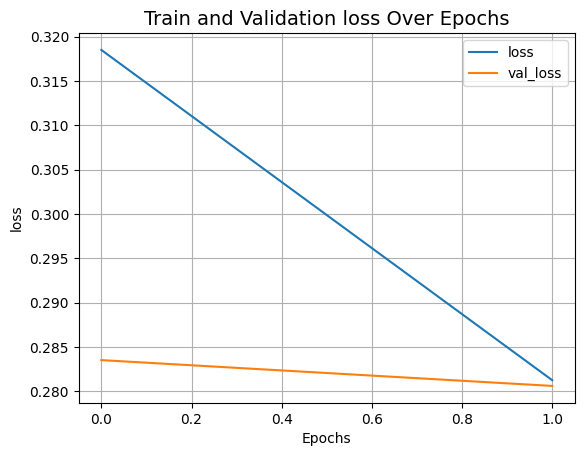

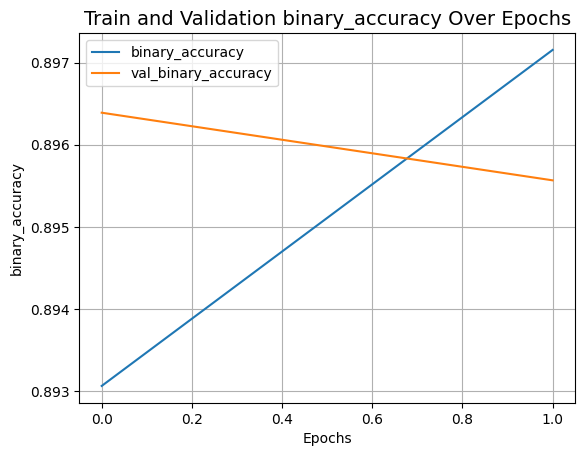

In [79]:
epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    # metrics=[tf.keras.metrics.BinaryAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.CategoricalAccuracy(), 
             tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.AUC(), 
             tf.keras.metrics.F1Score(average='macro'), 
             tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall()]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping_monitor]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [80]:
metrics = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(metrics[1] * 100, 2)}%.")

33/33 [==============================] - 0s 1ms/step - loss: 0.2755 - binary_accuracy: 0.8981 - categorical_accuracy: 0.4813 - accuracy: 0.0000e+00 - auc_1: 0.7930 - f1_score: 0.0367 - precision_1: 0.5201 - recall_1: 0.1883
Categorical accuracy on the test set: 89.81%.


In [31]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 14ms/step
Abstract: b'A female parole officer unwittingly gets involved with a handsome photographer who might be a serial killer.'
Label(s): ['Drama' 'Thriller']
Predicted Label(s): (Thriller, Crime, Drama)
 
Abstract: b'Sandy Wexler (Adam Sandler) is a talent manager working in Los Angeles in the 1990s, diligently representing a group of eccentric clients on the fringes of show business. His single minded devotion is put to the test when he falls in love with his newest client, Courtney Clarke, a tremendously talented singer who he discovers at an amusement park. Over the course of a decade, the two of them play out a star-crossed love story.'
Label(s): ['Comedy']
Predicted Label(s): (Comedy, Drama, Romance)
 
Abstract: b"In the middle of the night, deputy Philippe Dubaye wakes up his old friend Xavier Mar\xc3\xa9chal with disturbing news: he has just killed Serrano, a racketeer with extant political connections. Serrano kept proofs of Dubaye

In [32]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

predictions = []  # store predicted labels
labels = []  # store true labels

# iterate over the dataset
for text_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # append true labels
    labels.extend(label_batch)
    # compute predictions
    preds = shallow_mlp_model.predict(text_batch, verbose=0)
    # append predicted labels
    predictions.extend(preds)

predictions = np.array(predictions)
labels = np.array(labels)

In [64]:
df = pd.DataFrame(text_batch[0])
df.to_clipboard(index=False,header=False)

In [38]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds=[0.5]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    f1 = f1_score(labels, pred, average='macro')
   
    # print("Micro-average quality numbers")
    print("Threshold: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, accuracy, precision, recall, f1))

Threshold: 0.5000, Accuracy: 0.2255, Precision: 0.6327, Recall: 0.3552, F1-measure: 0.4298


/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
import os
model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

tf.saved_model.save(
    shallow_mlp_model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

INFO:tensorflow:Assets written to: models//model/1/assets


INFO:tensorflow:Assets written to: models//model/1/assets


SavedModel files: ['fingerprint.pb', 'variables', 'saved_model.pb', 'assets']


In [58]:
!saved_model_cli show --dir {model_export_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_6_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 79454)
      name: serving_default_dense_6_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_8'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 20)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [53]:
(pred == labels).sum() / (4128*20)

0.9239825581395349

In [305]:
# Binary accuracy doesn't give us much info since most labels are 0s
# For instance, if we predicted no genre for all movies, we would get
# a binary accuracy of ~0.897
(0 == labels).sum() / (4128*20)

0.8963299418604651

In [52]:
np.sum(np.all(np.equal(pred, labels), axis=1)) / (4128)

0.22553294573643412

In [243]:
pred.shape

(4128, 21)

In [274]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(labels, pred)
# print(cm)
# print( skm.classification_report(y_true,y_pred))

In [276]:
cm[0]

array([[4128,    0],
       [   0,    0]])

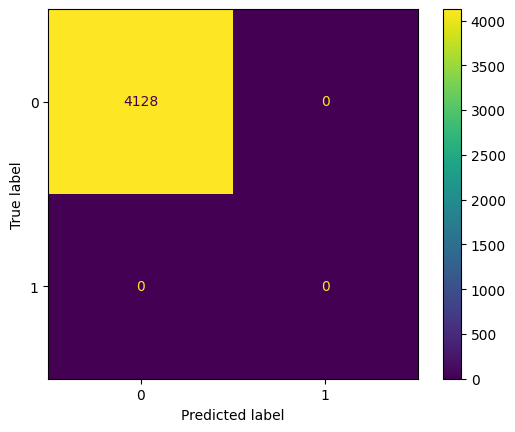

In [275]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=[0,1])
disp.plot()
plt.show()

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U33'), dtype('float32')) -> None

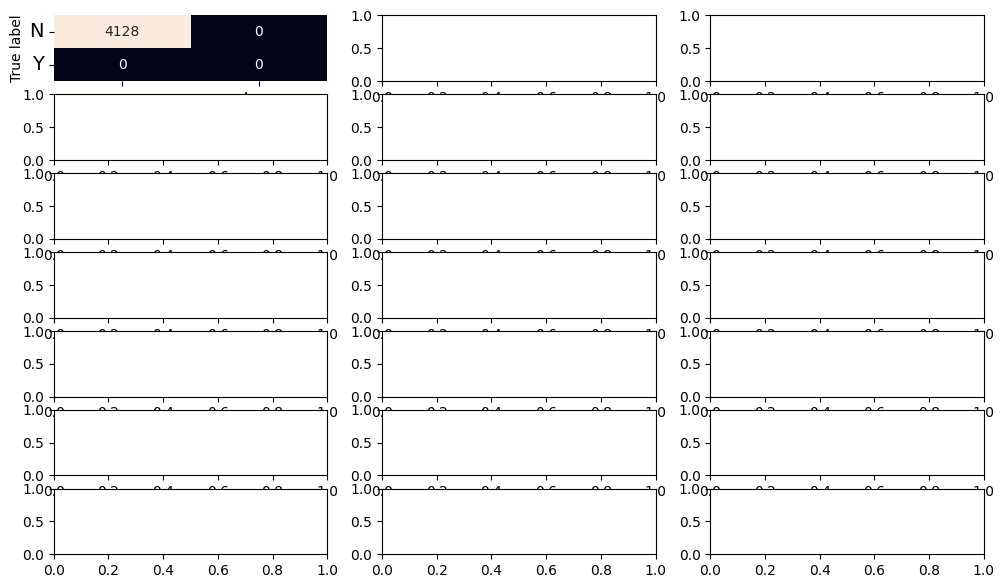

In [253]:
fig, ax = plt.subplots(7, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [273]:
cm.shape

(21, 2, 2)

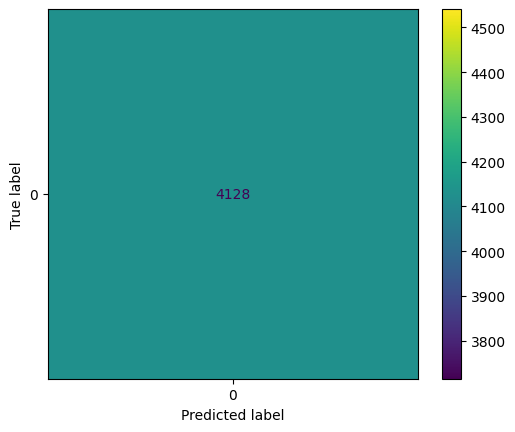

In [271]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(labels[:, i],
                                                   pred[:, i]))
disp.plot()

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

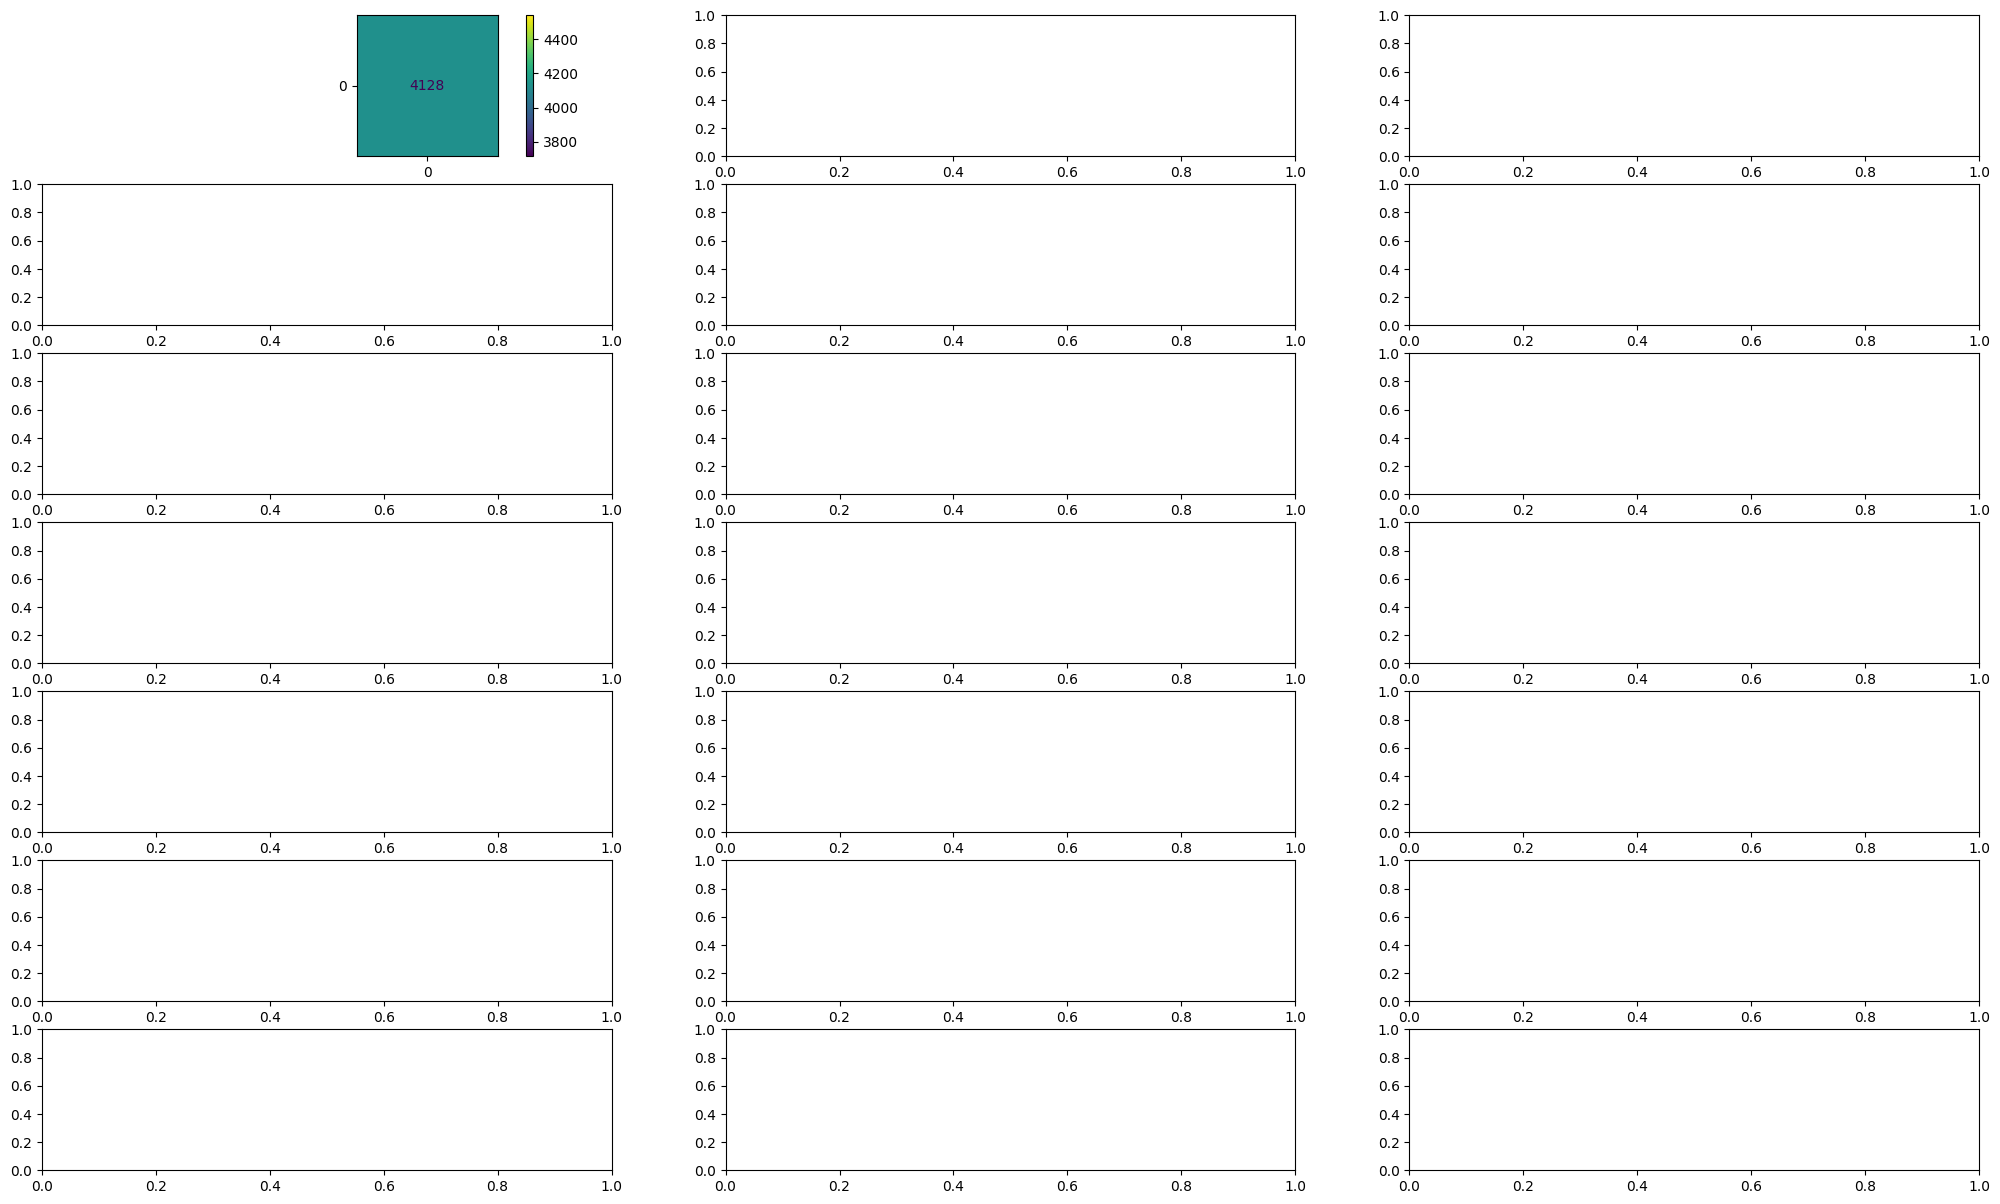

In [255]:
f, axes = plt.subplots(7, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(21):
    disp = ConfusionMatrixDisplay(confusion_matrix(labels[:, i],
                                                   pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<6:
        disp.ax_.set_xlabel('')
    if i%3!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()